# Idea
Do some feature ranking

| **Possible DataSources** |
| --- |
| SYS_data |
| KERN_data |
| FLS_data |
| RES_data |
| block_data |
| network_data |
| entropy_data |


In [1]:
DATA_SOURCE = "RES_data"
DEVICE_SOURCE = "Heqing_device2"

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

In [3]:
import sys
repo_base_path = Path("./../").resolve()
assert str(repo_base_path).endswith("csg_is"), f"{repo_base_path} is not a valid path to the CSG_IS repository" 

sys.path.append(str(repo_base_path))

from py_dataset import get_all_files_df
from py_dataset import read_in_files
from py_dataset import feature_plotting
from py_dataset import feature_selection

In [4]:
data_path = Path('/media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/')
assert data_path.exists()

In [5]:
df = get_all_files_df.main(data_path)
df.head(1)

txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device1/3_thetick_4h/collections.txt
txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device2/1_normal/note.txt
                                           file_path
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...
RangeIndex(start=0, stop=622, step=1)
filetype
csv    530
zip     92
Name: count, dtype: int64
                                           file_path filetype  filesize_bytes
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...      csv           49419
data_source
SYS_data        92
KERN_data       91
FLS_data        91
RES_data        91
block_data      91
network_data    91
entropy_data    75
Name: count, dtype: int64


,file_path,filetype,filesize_bytes,researcher_name,device_name,label,data_source,file_name,device
0,/media//DC/MAP_CreationOfNewDatasetsForDFL/...,csv,49419,Heqing,device1,1_normal,block_data,e4_5f_01_68_35_e6.csv,Heqing_device1


In [6]:
single_dev_single_data_source = df[(df["device"] == DEVICE_SOURCE) & (df["data_source"] == DATA_SOURCE)]
assert len(single_dev_single_data_source["device"].unique()) == 1 and len(single_dev_single_data_source["data_source"].unique()) == 1
print(single_dev_single_data_source.shape)

(19, 9)


In [7]:
vectors = read_in_files.get_all_columns_from_single_data_source_for_csv_files(single_dev_single_data_source)
vectors.shape

! Dropped rows in DataFrames: (2,)
time                                                time
cpu                                                  cpu
seconds                                          seconds
ioread                                            ioread
iowrite                                          iowrite
                                         ...            
rpm:rpm_return_int                    rpm:rpm_return_int
fib:fib_table_lookup                fib:fib_table_lookup
raw_syscalls:sys_enter            raw_syscalls:sys_enter
random:credit_entropy_bits    random:credit_entropy_bits
timestamp                                            NaN
Name: 318, Length: 118, dtype: object
time                                                time
cpu                                                  cpu
seconds                                          seconds
ioread                                            ioread
iowrite                                          iowrite
               

(9898, 117)

#### Preprocessing

In [8]:
vectors.reset_index(inplace=True, drop=True)  # drops: "timestamp"

cols_to_exclude_from_scaling = ["label"]

vectors = feature_plotting.test_transform_all_to_numeric_columns(vectors, cols_to_exclude_from_scaling)
vectors_scaled = feature_plotting.minmax_scale_features(vectors,
                                                        remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

vectors_robust_scaled = feature_plotting.minmax_scale_features(vectors,
                                                               remove_outliers_iqr_all_columns=True,
                                                               cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

In [9]:
X = vectors_scaled.drop(columns=["label"])
Y = vectors_scaled["label"]

X_ROBUST = vectors_robust_scaled.drop(columns=["label"])

In [10]:
print(X_ROBUST.dropna().shape, X_ROBUST.shape)

X_ROBUST.dropna(inplace=True)
Y_ROBUST = vectors_robust_scaled.dropna()["label"]

(3386, 116) (9898, 116)


#### Ranking

In [11]:
print(feature_selection.get_low_variance_features(X, threshold=0.0))
print(f"{feature_selection.get_low_variance_features(X_ROBUST, threshold=0.0)}: Will be removed if outliers are removed")

['armv7_cortex_a15/br_immed_retired/', 'armv7_cortex_a15/ld_retired/', 'armv7_cortex_a15/pc_write_retired/', 'armv7_cortex_a15/st_retired/', 'armv7_cortex_a15/unaligned_ldst_retired/', 'armv7_cortex_a15/cid_write_retired/']
['ioread', 'ioreadbytes', 'ioreadtime', 'read_merge', 'err_in', 'err_out', 'drop_in', 'drop_out', 'armv7_cortex_a15/br_immed_retired/', 'armv7_cortex_a15/ld_retired/', 'armv7_cortex_a15/pc_write_retired/', 'armv7_cortex_a15/st_retired/', 'armv7_cortex_a15/unaligned_ldst_retired/', 'armv7_cortex_a15/cid_write_retired/', 'block:block_bio_frontmerge', 'block:block_split', 'ext4:ext4_ext_load_extent', 'ext4:ext4_sync_file_enter', 'ext4:ext4_free_inode', 'ext4:ext4_evict_inode', 'ext4:ext4_unlink_enter', 'writeback:wait_on_page_writeback']: Will be removed if outliers are removed


In [12]:
X.drop(columns=feature_selection.get_low_variance_features(X, threshold=0.0), inplace=True)
X_ROBUST.drop(columns=feature_selection.get_low_variance_features(X_ROBUST, threshold=0.0), inplace=True)

In [13]:
scores_by_label = feature_selection.calculate_scores_by_label(X, Y)
scores_by_label.groupby("feature")[[ "chi2", "f_classif", "mutual_info_classif"]].mean()
singles = scores_by_label.groupby("feature")[[ "chi2", "f_classif", "mutual_info_classif"]].mean()

Label: 1_normal
Label: 2_ransomware
Label: 3_thetick
Label: 4_bashlite
Label: 5_httpbackdoor
Label: 6_beurk
Label: 7_backdoor
Label: 8_bdvl
Label: 9_xmrig


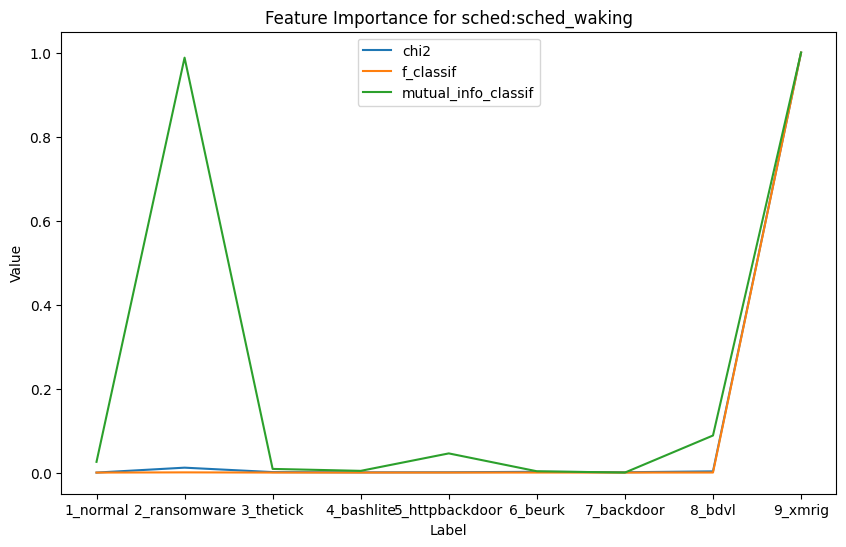

In [14]:
test_df = scores_by_label.copy()
feature_selection.sort_by_mean(test_df)
test_df.reset_index(inplace=True)
best_Feature = test_df.loc[0]["feature"]

feature_selection.plot_scores_by_label_single_plot_single_feature( scores_by_label, best_Feature)

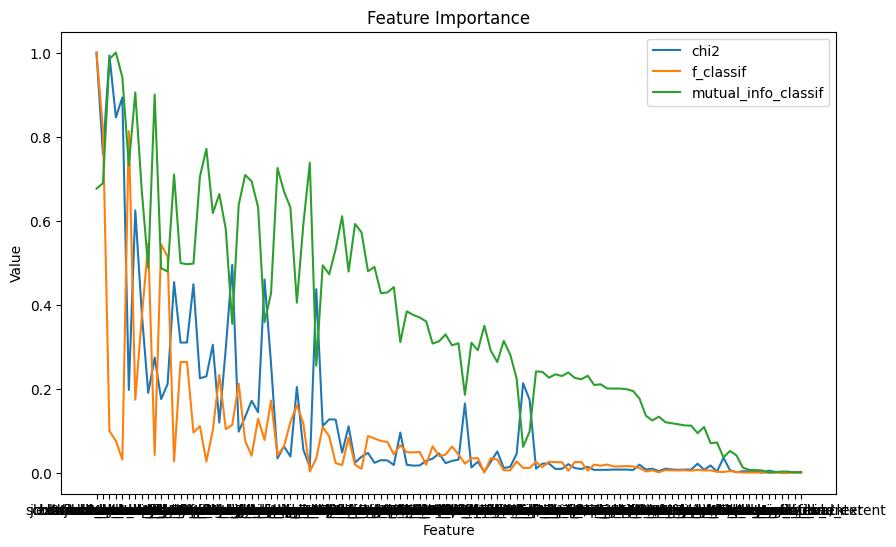

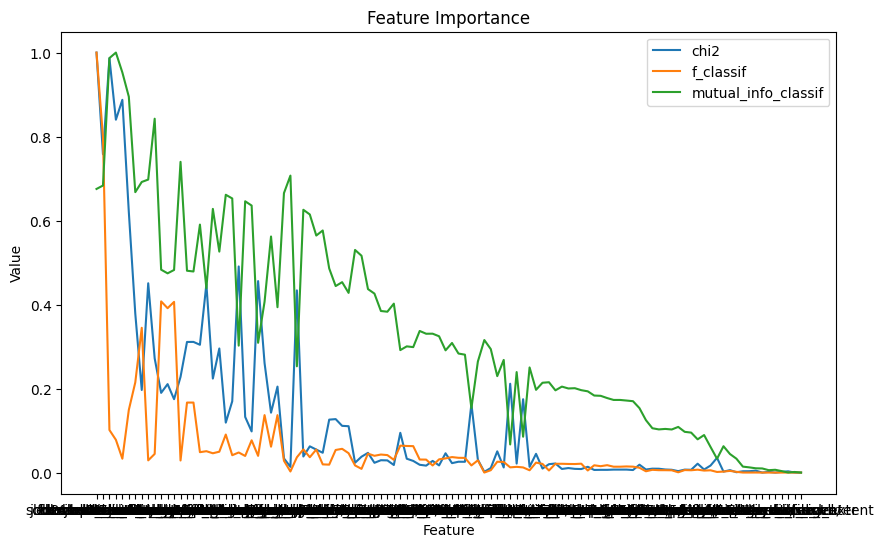

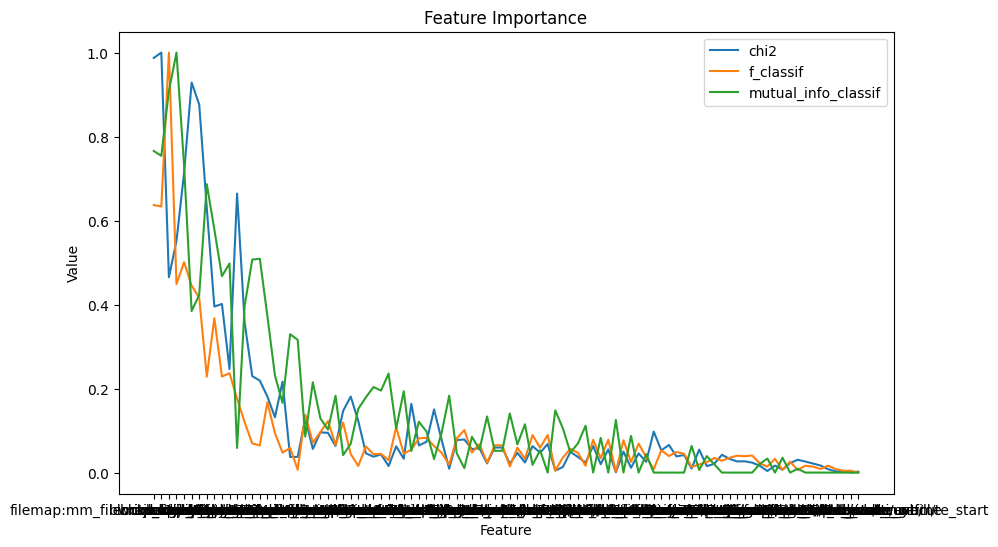

In [15]:
scores = feature_selection.calculate_scores(X, Y)
feature_selection.plot_single_scores(scores)

singles = singles.loc[scores["feature"].unique()]
singles = singles.reset_index()
feature_selection.plot_single_scores(singles)

scores_robust = feature_selection.calculate_scores(X_ROBUST, Y_ROBUST)
feature_selection.plot_single_scores(scores_robust)

9_xmrig
8_bdvl
2_ransomware
6_beurk
5_httpbackdoor
3_thetick
1_normal
4_bashlite
7_backdoor


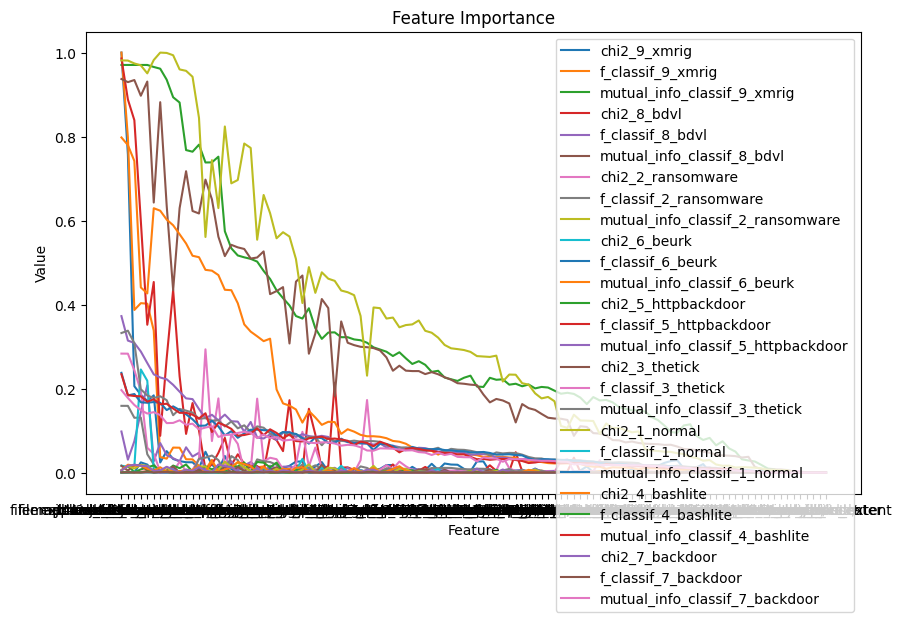

In [16]:
feature_selection.plot_scores_by_label_single_plot(scores_by_label)

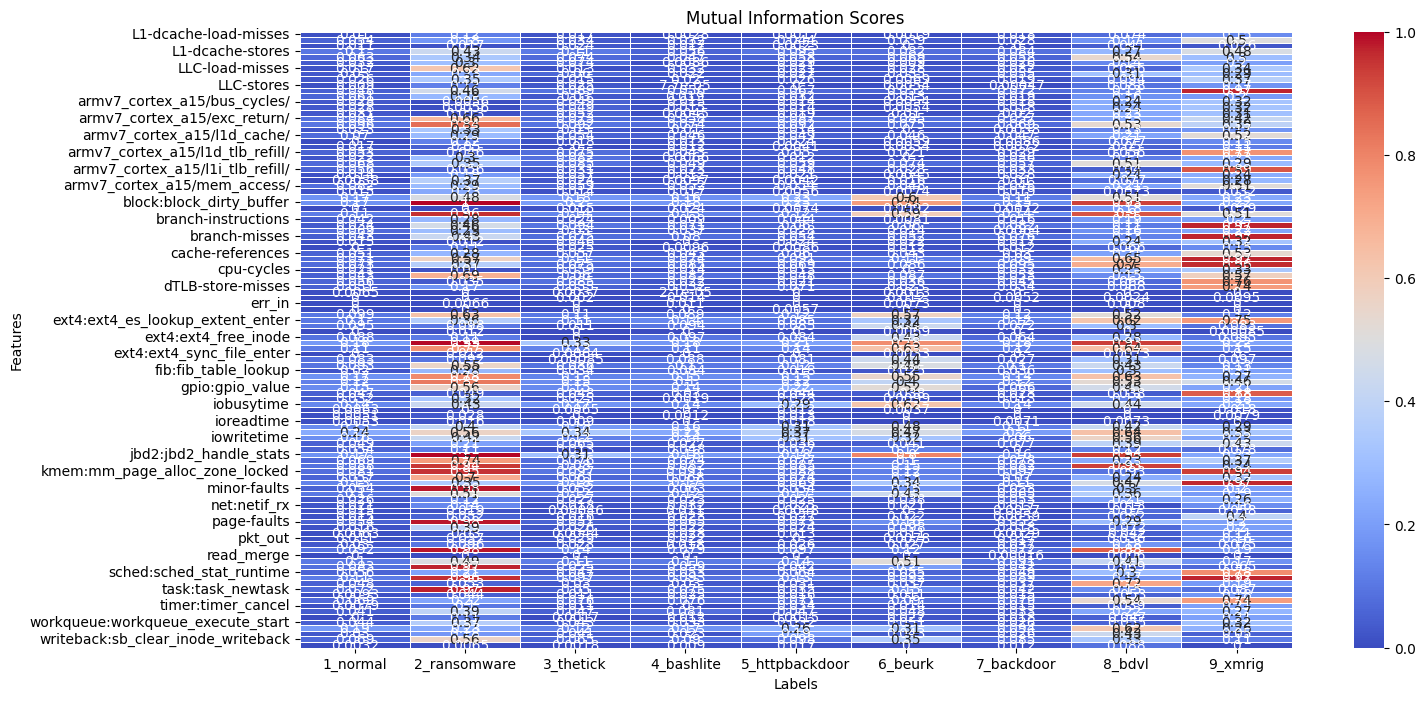

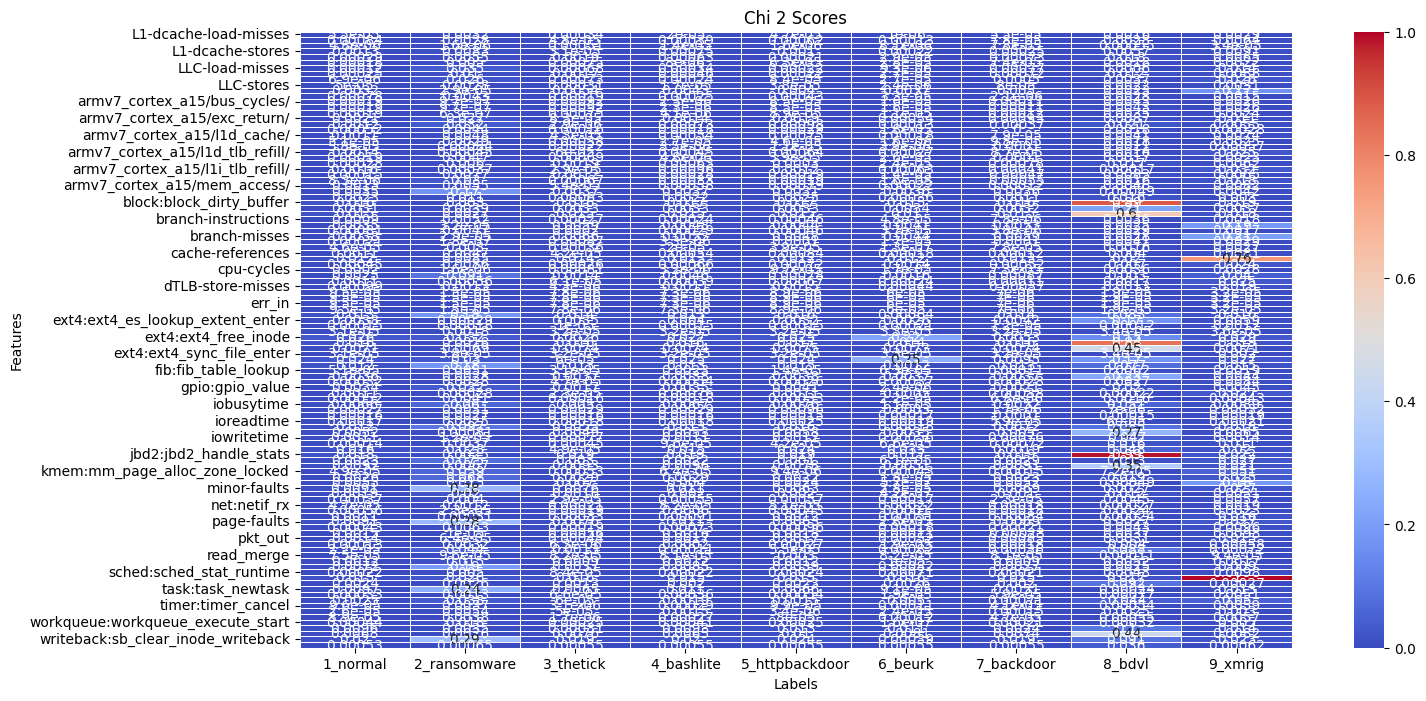

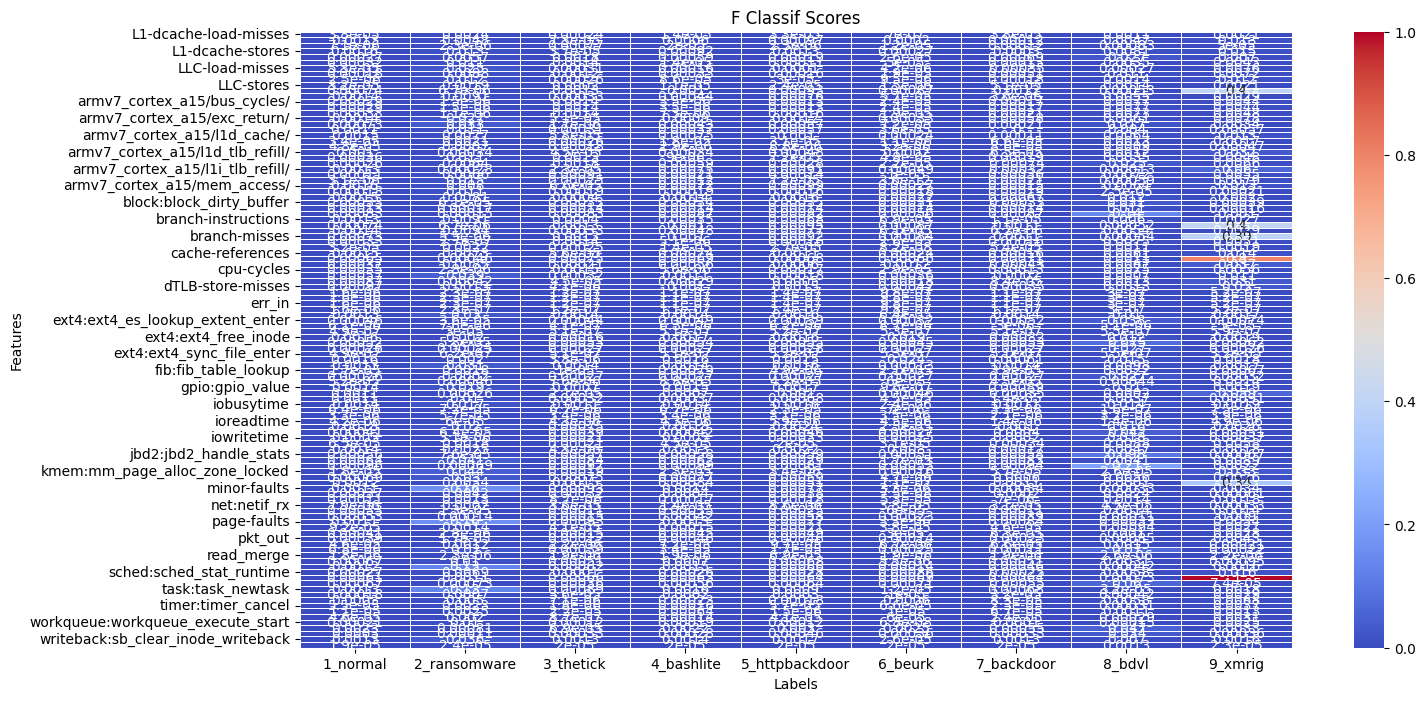

In [17]:
feature_selection.heatmap_scores_by_label_versus_features(scores_by_label)

Label: 1_normal
Label: 2_ransomware
Label: 3_thetick
Label: 4_bashlite


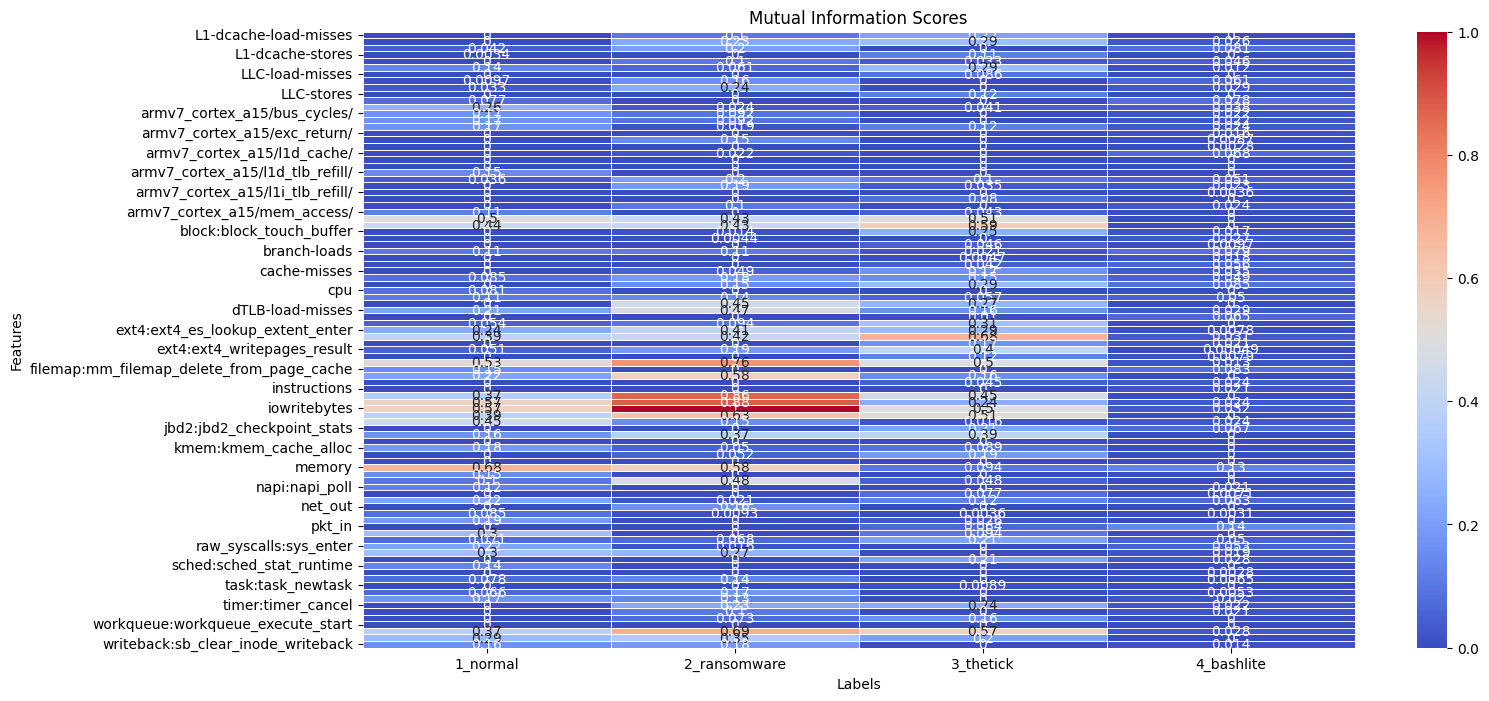

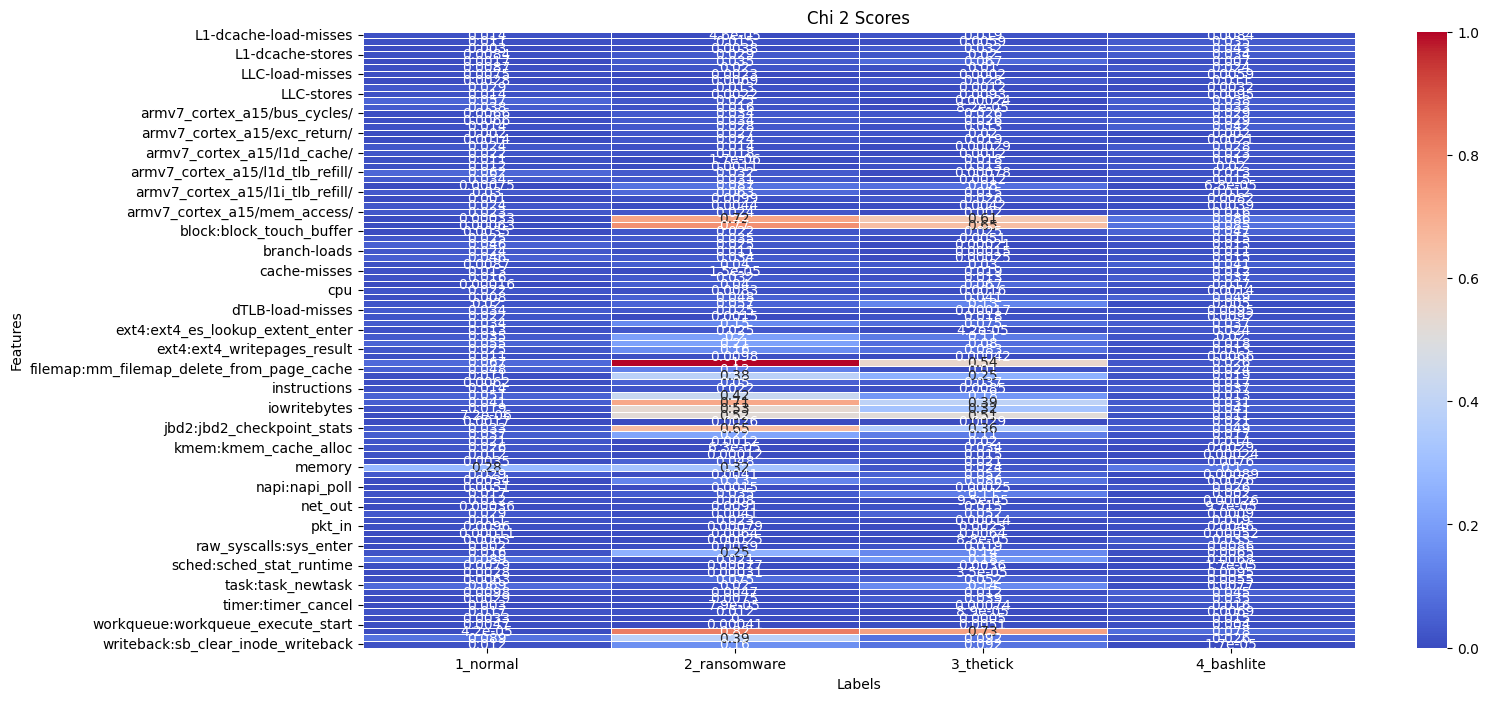

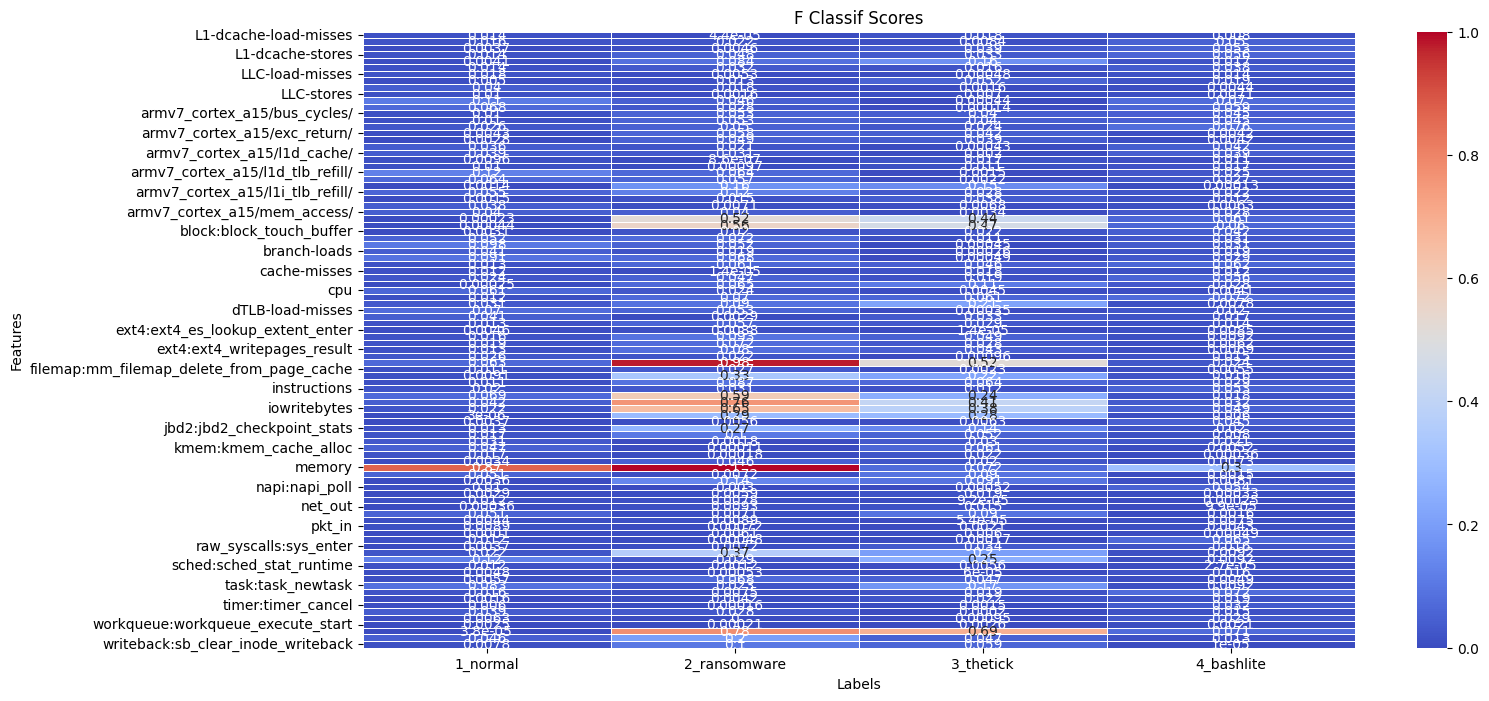

In [18]:
scores_by_label_robust = feature_selection.calculate_scores_by_label(X_ROBUST, Y_ROBUST)
feature_selection.heatmap_scores_by_label_versus_features(scores_by_label_robust)

#### Storing scores

In [19]:
output_dir = repo_base_path / "feature_selection" / "result"
output_file_X = output_dir / f"{DATA_SOURCE}_{DEVICE_SOURCE}_featurescores.csv"
output_file_X_ROBUST = output_dir / f"{DATA_SOURCE}_{DEVICE_SOURCE}_featurescores_ROBUST.csv"

In [20]:
scores_by_label.to_csv(output_file_X, index=False)
scores_by_label_robust.to_csv(output_file_X_ROBUST, index=False)